In [39]:
# default_exp gmm_clustering

# Gaussian Mixture Model clustering of all COI

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [45]:
# export
from ehv import correlation, preprocessing_pipeline
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from multiprocessing import Pool
from sklearn import metrics

In [4]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    None, "Low/*.cif")
df = e_load.clean_column_names(df)
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

## Compute PCA representations

In [5]:
# note that we are accessing a subset of the pipeline (dropping UMAP step)
pipe = preprocessing_pipeline.make_pipeline_1()[:-1]

In [6]:
df = pipe.fit_transform(df)

In [7]:
umap_projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/b4fb7334-7ca5-408a-a136-256358f81190.dat")
df = pandas.concat([df, umap_projection.reset_index(drop=True)],axis=1)

## Fit Bayesian GMM

In [ ]:
# export

def func(X, i, seed):
    cluster_labels = BayesianGaussianMixture(n_components=i, covariance_type="diag", random_state=seed, max_iter=1000).fit_predict(X)
    return {
        "n_components": i,
        "seed": seed,
#         "silhouette": metrics.silhouette_score(X, cluster_labels, metric="euclidean"),
        "cal-har": metrics.calinski_harabasz_score(X, cluster_labels),
        "dav-boul": metrics.davies_bouldin_score(X, cluster_labels)
    }

def n_components_search(df, n_jobs, comp_range, repeats):
    data = []

    with Pool(processes=n_jobs) as pool:
        X = df.filter(regex="feat_pca")

        promises = []
        for n_comps in comp_range:
            numpy.random.seed(42)
            for rep in range(repeats):
                seed = 42 + numpy.random.randint(100)
                p = pool.apply_async(func, args=(X.copy(), n_comps, seed))
                promises.append(p)

        for i, p in enumerate(promises):
            data.append(p.get())
            print(i, end=" ")
        print()
        
    return data

In [36]:
data = pandas.DataFrame(data)

<AxesSubplot:xlabel='n_components', ylabel='cal-har'>

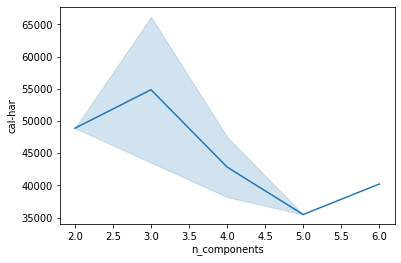

In [37]:
seaborn.lineplot(data=data, x="n_components", y="cal-har")

<AxesSubplot:xlabel='n_components', ylabel='dav-boul'>

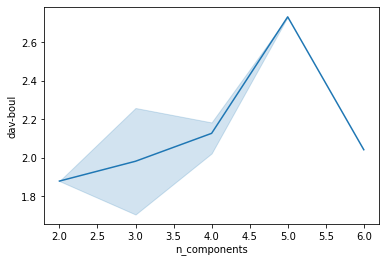

In [38]:
seaborn.lineplot(data=data, x="n_components", y="dav-boul")

In [12]:
df["meta_cluster_label"] = model.predict(df.filter(regex="feat_pca"))

In [13]:
len(df["meta_cluster_label"].unique())

10

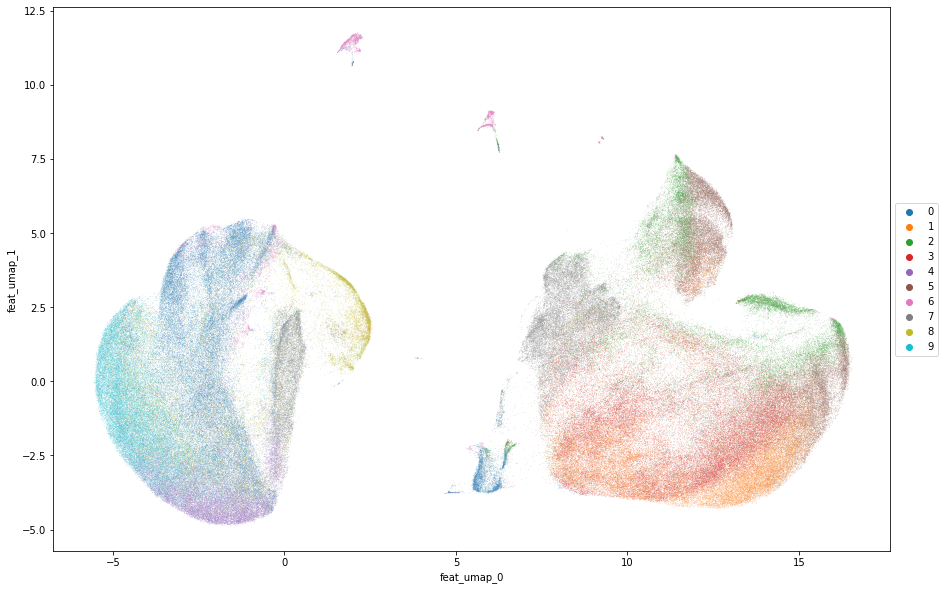

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
seaborn.scatterplot(
    data=df[df["meta_label"] != "unknown"], 
    x="feat_umap_0", y="feat_umap_1", hue="meta_cluster_label", 
    edgecolors="none", s=0.3, alpha=0.5, legend=True,
    palette=seaborn.color_palette(n_colors=len(df["meta_cluster_label"].unique())),
    ax=ax
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.jpg")

## Permutation importance on cluster assignments

In [26]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

X = df.filter(regex="feat").drop(columns=df.filter(regex="pca|umap"))
y = df["meta_cluster_label"]
classifier.fit(X, y)

GaussianNB()

In [27]:
classifier.score(X, y)

0.7483755843619578

In [28]:
from sklearn.inspection import permutation_importance
r = permutation_importance(classifier, X, y, n_repeats=10, random_state=42, n_jobs=-1)

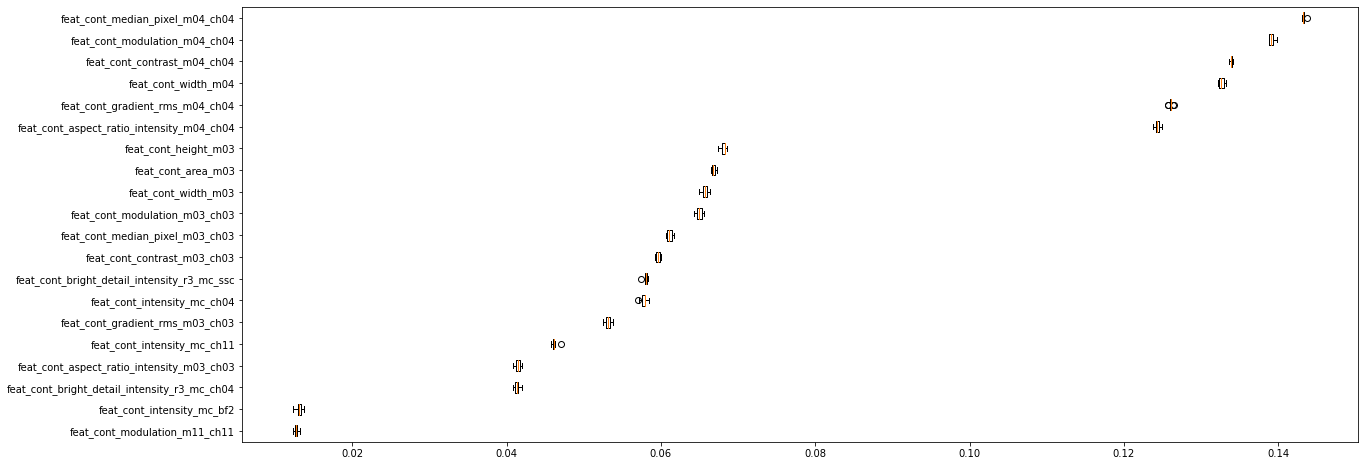

In [35]:
perm_sorted_idx = r.importances_mean.argsort()[-20:]

fig, ax = plt.subplots(figsize=(20, 8))
_ = ax.boxplot(r.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])